Teljesen összekötött neural network
(ebben a példában 6 db hidden layerünk lesz)

![alt text](https://www.codeproject.com/KB/AI/1261763/artificial_neural_network.png)

egy darab neuron belőle

![alt text](https://miro.medium.com/max/3000/1*WRG_Re8vGVuHDYigtq2IBA.jpeg)



Extracting tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Input size: 784
Label size: 10
Iteration: 0, loss: 2.2899833, accuracy: 0.109375
Iteration: 100, loss: 0.48960862, accuracy: 0.828125
Iteration: 200, loss: 0.21773748, accuracy: 0.953125
Iteration: 300, loss: 0.24107319, accuracy: 0.90625
Iteration: 400, loss: 0.12502053, accuracy: 0.96875
Iteration: 500, loss: 0.06018923, accuracy: 0.96875
Iteration: 600, loss: 0.13116547, accuracy: 0.96875
Iteration: 700, loss: 0.20606267, accuracy: 0.953125
Iteration: 800, loss: 0.10017985, accuracy: 0.96875
Iteration: 900, loss: 0.16557395, accuracy: 0.953125


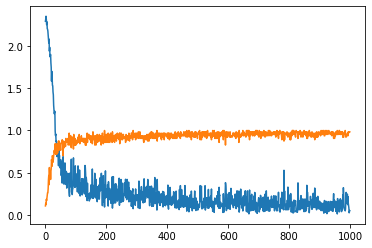

In [3]:
#imports

#ez a kettő kell feltétlenül a neurhálónkhoz
import tensorflow as tf
import numpy as np

#ezt csak a random batch elem kiválasztásához használjuk (a sessionünkben)
import random

#ezt meg ha valami grafikont meg akarunk jeleníteni
import matplotlib.pyplot as plt

#itt beimportáltuk az mnist datasetet és megadtuk a labelt one_hot fromában 
#(a onehot azért fontos, mert a softmax_cross_entopynk amit használunk csak azt eszi meg)
from tensorflow.examples.tutorials.mnist import input_data as data 
mnist_data = data.read_data_sets('tmp/MNIST_data/', one_hot=True)


#finding the data and the label shapes

#jelen esetben csak a datáét irattam ki
#ebből lesz lentebb az input_size
print('Input size: ' + str(mnist_data.train.images.shape[1]))

#mivel one_hot a labelünk így elég lekérni az alakját
print('Label size: ' + str(mnist_data.train.labels.shape[1]))


#hyperparameters

#ez a fullyconnected inputja (x1, x2, ..., x784) egy 784 elemű vektor
input_size = mnist_data.train.images.shape[1]
#ez a fullyconnected outputja (y1, y2, ..., y10) egy 10 elemű vektor
#csak akkor adhatom meg így ha már one_hot alakú
num_classes = mnist_data.train.labels.shape[1]
#batch mérete, egyetlen kritérium, hogy kisebb legyen, mint mnist_data.train.images.shape[0]
batch_size = 64
#itt az egyes layerek mérete van, a hiddenekét most így határoztuk meg
layer = [input_size, 1024, 2048, 1024, 512, 256, 128, num_classes]
#a sessionömben lévő iterációk száma
num_iterations = 1000


#graph building

#minden új gráf építése előtt resetelni, kell mert különben lehetnek zavaró előzőből megmaradt elemek
#ha ez előtt van tensorflow függény az is resetelődni fog
tf.reset_default_graph()

#két placeholder amelyek float32 típusúak, a beléjük töltendő adatokat dinamikusan kasztolja ha kell
#és az alakjuk a batch size és az input/output layer mérete
input_data = tf.placeholder(tf.float32, [batch_size, input_size])
expected_output = tf.placeholder(tf.float32, [batch_size, num_classes])

#itt megadjuk az inputot, amit majd a sessionön belül fog megkapni a gráf
current_input = input_data

#végigiterálunk az összes layeren
for i in range(0, len(layer)-1):

  #itt meghatározunk egy adott layert
  with tf.variable_scope('layer' + str(i)):

    #megadjuk a súlymátrixot melynek az input vector (vagy az előző layer outputja) lesz az oszlopainak a száma
    #és a sorok száma meg az adott layer neuronjainak a száma
    #ez látszik a fenti 1. ábrán hogy miért
    w=tf.get_variable('w', shape=[layer[i], layer[i+1]])

    #itt megadjuk egy vektorban a neuronokhoz tartozó biast
    b=tf.get_variable('b', shape=[layer[i+1]])

    #itt matmul elvégzi nekünk a szummáig a második képen látható műveletet
    #számít a sorrend így, először az előző layer outputja és utána a súlymátrix
    current_input=tf.matmul(current_input, w)

    #itt csak hozzáadjuk a biast
    current_input=tf.add(current_input, b)
    
    #itt azért van if mert a fullyconnectedben az output layerre nem kell activation function
    if(len(layer)-2 != i):
      
      #maga az activation function (nem muszáj RELUt használni)
      current_input = tf.nn.relu(current_input)


#loss meghatározása
with tf.variable_scope('loss'):
  #softmaxot használunk egy reduce meanbe (átlagol a reduce_mean)
  #a softmax a random adatokat amik kijönnek a networkből 0 és 1 közé rakja
  #a crossentropy pedig megadja a megadott két paraméter távolságát
  #a softmaxnak több függvénye is van, ahogy figyeltem eltérnek benne a paraméter sorrendek
  #szóval érdemes meghatározni hogy melyik paramétert adjuk épp meg
  loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=expected_output, logits=current_input))

#optimizer megadása
with tf.variable_scope('optimizer'):
  #úgy határozzuk meg hogy a learning ratet megadjuk (adamnél a 1e-4 az egyik legoptimálisabb)
  #és úgy konfiguráljuk a trainingjét hogy a loss értékét minimalizálja a súlyok és a bias állítgatásával
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

#accuracy megadása (szerintem opcionális)
with tf.name_scope('accuracy'):
  #megnézem hogy a várt és a kapott output megegyezik-e
  correct_predicitions = tf.equal(tf.argmax(current_input, 1), tf.argmax(expected_output, 1))
  #majd átcastolom megfelelő formátumra és átlagolom
  accuracy = tf.reduce_mean(tf.cast(correct_predicitions, tf.float32))


#session

#itt tanítjuk be a hálónkat
with tf.Session() as sess:

  #futtatjuk a sessiont és az összes eddig meghtározott globális variablet odaadjuk neki, hogy rendelkezzen felettük
  sess.run(tf.global_variables_initializer())

  #megadok két 0ákkal töltött tömböt a későbbi ábrázoláshoz
  loss_plot = np.zeros(num_iterations)
  acc_plot = np.zeros(num_iterations)

  #végigiterálunk egy nagyobb számmal, hogy releváns legyen a tanításunk
  for i in range(num_iterations):

    #veszünk egy random batch méretű elemet 
    used_in_batch = random.sample(range(len(mnist_data.train.images)), batch_size)
    
    #a kiválasztott elemből meghatározzuk az adott inputot és várt outputot
    batch_x = mnist_data.train.images[used_in_batch]
    batch_y = mnist_data.train.labels[used_in_batch]

    #itt futtatok egy újabb sessiont, ahol megahtározom az adott loss-t és accuracyt, a placeholdereknek odaadott random batcheimből
    #accuracy nélkül: _, l = sess.run([optimizer, loss], feed_dict={input_data: batch_x, expected_output: batch_y})
    _, l, acc = sess.run([optimizer, loss, accuracy], feed_dict={input_data: batch_x, expected_output: batch_y})

    #beletöltöm a tömbjeimbe az adott iteráció eredményeit
    loss_plot[i] = l
    acc_plot[i] = acc

    #minden 100. iteráciban kiiratom az loss és accuracy aktuális eredményeit
    if (i%100 == 0):
      print('Iteration: ' + str(i) + ', loss: ' + str(l) + ', accuracy: ' + str(acc))


#végül kiplotolom az elmentett loss és accuracy értékeket
plt.plot(loss_plot)
plt.plot(acc_plot)

